#  Классификация текстов с использованием эмбеддингов слов.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/text/stable/vocab.html
* https://pytorch.org/text/stable/transforms.html
* https://rusvectores.org/
* https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* https://github.com/natasha/navec
* https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
* https://torchmetrics.readthedocs.io/en/stable/

## Задачи для совместного разбора

1\. Реализуйте модель для классификации текстов с использованием слоя `nn.Embedding`. Заморозьте веса слоя эмбеддингов.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
X = th.randint(0, 1000, size=(16, 20)).long()
y = th.LongTensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=1000, embedding_dim=100)
        self.fc = nn.Linear(in_features=100, out_features=2)
    def forward(self, X):
        # X : batch_size x seq_len
        e = self.emb(X) #batch_size x seq_len x emb_dim
        e = e.mean(dim=1) # batch_size x emb_dim
        out = self.fc(e) # batch_size x 2
        return out

In [ ]:
model = Net()
y_pred = model(X)

In [ ]:
y_pred.shape

torch.Size([16, 2])

In [ ]:
model.emb.weight.requires_grad_(False)
model.emb.weight.requires_grad

False

2\. Используя `torchmetrics`, рассчитайте значение accuracy по эпохам с использованием мини-пакетного градиентого спуска.

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.0 MB/s eta 0:00:00


In [ ]:
import torchmetrics

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn

In [ ]:
dset = TensorDataset(X, y)
loader = DataLoader(dset, batch_size=4)

n_epochs = 5
lr = 0.001

model = Net()
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    preds, trues = [], []
    running_correct, running_count = 0, 0
    running_acc, running_steps = 0, 0

    acc_m = torchmetrics.Accuracy(task='binary')

    for step, (X_b, y_b) in enumerate(loader):
        y_pred = model(X_b)
        loss = crit(y_pred, y_b)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # v1

        # preds.extend(list(y_pred.argmax(dim=1)))
        # trues.extend(list(y_b))

        # v2

        # running_correct += (y_pred.argmax(dim=1) == y_b).sum()
        # running_count += len(y_b)

        # v3

        # acc = (y_pred.argmax(dim=1) == y_b).float().mean()
        # running_acc += acc
        # running_steps += 1
        # print(f'epoch: {epoch}, step= {step}, {acc.item()}')

        # v4

        acc_m.update(y_pred.argmax(dim=1), y_b)
    acc_epochs = acc_m.compute()
    print(acc_epochs)

    # pred = th.tensor(preds)
    # trues = th.tensor(trues)

tensor(0.5625)
tensor(0.5625)
tensor(0.5625)
tensor(0.5625)
tensor(0.5625)


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Считайте файл `lenta_news.csv` и разбейте на обучающую и тестовую выборку. Выполните предобработку текста и создайте Vocab на основе обучающей выборки (токен - слово). Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [ ]:
import torch as th
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd

df = pd.read_csv('lenta_news.csv')#, usecols=['text', 'topic'])

UnicodeDecodeError: ignored

In [ ]:
df.head()

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'],
    df['topic'],
    test_size = 0.2,
    random_state=42
)

In [ ]:
import re
corpus = []
for sent in X_train:
    sent =  re.sub("[^А-Яа-я']+", ' ', sent.lower())
    words = word_tokenize(sent)
    corpus.append(words)

AttributeError: ignored

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
vocab_train = build_vocab_from_iterator(corpus, specials = ['<pad>', '<unk>'])

In [ ]:
len(vocab_train.get_stoi())

165634

<p class="task" id="2"></p>


2\. Создайте класс `NewsDataset`. Реализуйте метод `__getitem__` таким образом, чтобы он возвращал набор индексов токенов для текста новости (или новостей, если используются срезы) и метки классов для этих новостей. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами категории новостей. Создайте два объекта класса `NewsDataset` (для обучающей и тестовой выборки).

Выведите на экран результат выполнения `train_dataset[0]` и `train_dataset[:3]`

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import Dataset
from nltk.tokenize import RegexpTokenizer
import torchtext.transforms as T

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, df):
      self.df = df
      self.label = list(df['topic'].map(
        {'Интернет и СМИ': 0, 'Культура': 1, 'Экономика': 2, 'Спорт': 3}
      ))
      tokenizer = RegexpTokenizer(r'(<pad>|<unk>|<sos>|<eos>|\w+)')
      self.corpus = []
      for sent in df['text']:
          sent =  re.sub("[^А-Яа-я']+", ' ', sent.lower())
          words = tokenizer.tokenize(sent)
          self.corpus.append(words)
      self.vocab = build_vocab_from_iterator(self.corpus, specials = ['<pad>', '<unk>'])
      self.transform = T.Sequential(
          T.ToTensor(0),
          T.PadTransform(max_length=1000, pad_value=0)
      )

    def __getitem__(self, idx):
      t = self.corpus[idx]
      l = self.label[idx]

      #if type(t[0]) == str:
      if type(idx) == int:
          vectors = [self.vocab.lookup_indices([word])[0] for word in t]
      else:
          vectors = [[self.vocab.lookup_indices([word])[0] for word in sent] for sent in t]
      return self.transform(vectors), th.tensor(l)
    def __len__(self):
        return len(self.df)

In [ ]:
df_train = pd.DataFrame({'text':X_train, 'topic':y_train})
df_test = pd.DataFrame({'text':X_test, 'topic':y_test})

In [ ]:
nws_train = NewsDataset(df_train)
nws_test = NewsDataset(df_test)

In [ ]:
nws_train[0]

(tensor([   997,   2504,  25403,   3612,  31459,   2157,  69191,  47960,   5316,
              2,    212,      2,   1110,   2050,   5406,  54902,   2158,     10,
             21,      2,    743,   1723,   1051,      2,  11150,   4689,    995,
              3,     11,   1336,      4,   7652,   1235,   1035,  82631,   3732,
            838,   1202,  70539,  39438,     65,  44639,      7,   9478,   1638,
            206,    789,    578,      4,   7652,   2157,  47960, 101764,     11,
            114,    727,    387,      2,    165,     15,   4133,  67250,   2157,
          47960,   9774,      2,     29,      2, 155455,      3,  11538,    743,
              2,  15956,   8622,    903,    376,   1124,  19333,  10014,     61,
              8,    248,     93,   2998,    916,      5,  13420,   2193,  13057,
          12246,   3272,    486,  15631,   2383,   7122,  18887,   1095, 153900,
              2,    301,    508,   1083,   5628,  68177,   8769,    581,  50124,
              2,   3332,    

In [ ]:
nws_train[:3]

(tensor([[  997,  2504, 25403,  ...,     0,     0,     0],
         [ 3910, 46716, 14140,  ...,     0,     0,     0],
         [ 1188, 13995,  9572,  ...,     0,     0,     0]]),
 tensor([1, 2, 1]))

<p class="task" id="3"></p>

3\. Реализуйте модель, которая получает на вход батч новостей (в виде индексов токенов), пропускает его через слой `nn.Embedding` (матрица эмбеддингов инициализируется случайным образом), после чего передает полученные эмбеддинги части-классификатору (который состоит из некоторого количества полносвязных слоев). Для получения эмбеддинга для предложения на основе эмбеддингов слов воспользуйтесь любой функцией агрегации, сохраняющей размерности векторов (сумма, усреднение и т.д.).

Решите задачу классификации новостей. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики f1 на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchmetrics

In [ ]:
class Net(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, out_features):
    super().__init__()
    self.emb = nn.Embedding(
        num_embeddings = num_embeddings, embedding_dim = embedding_dim
      )
    self.fc1 = nn.Linear(
        in_features = embedding_dim, out_features = 50
      )
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(
        in_features = 50, out_features = out_features
      )

  def forward(self, X):
    e = self.emb(X)
    e = e.mean(dim=1)
    out = self.fc1(e)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
model = Net(
    num_embeddings=len(vocab_train),
    embedding_dim=300,
    out_features=4
    )

In [ ]:
from torch.utils.data import DataLoader
dl = DataLoader(nws_train, batch_size=200)

In [ ]:
dl_test = DataLoader(nws_test, batch_size=200)

In [ ]:
%%time
lr = 0.1
n_epochs = 10

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_f1, test_f1 = [], []

for epoch in range(n_epochs):
    if epoch % 5 == 0:
        print(epoch)
    train_losses = []
    f1_m = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_, y_ in dl:
        out = model(X_)
        loss = crit(out, y_)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

        f1_m.update(out.argmax(dim=1), y_)

    losses.append(th.tensor(train_losses).mean())
    f1_epochs = f1_m.compute()
    train_f1.append(f1_epochs)

    model.eval()
    f1_m_test = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_test, y_test in dl_test:
        out = model(X_test)
        f1_m_test.update(out.argmax(dim=1), y_test)
    f1_epochs_test = f1_m_test.compute()
    test_f1.append(f1_epochs_test)
    model.train()

0
5
CPU times: user 7min 44s, sys: 6min 29s, total: 14min 13s
Wall time: 14min 14s


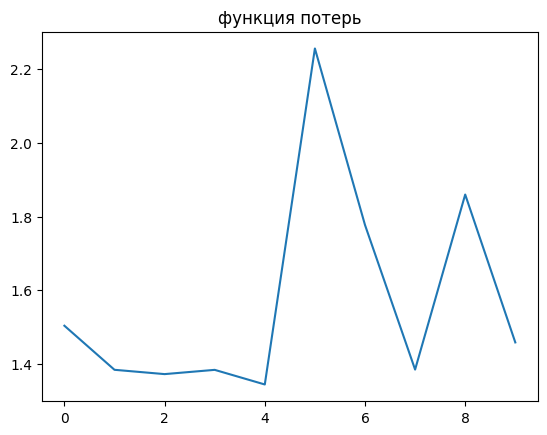

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('функция потерь');

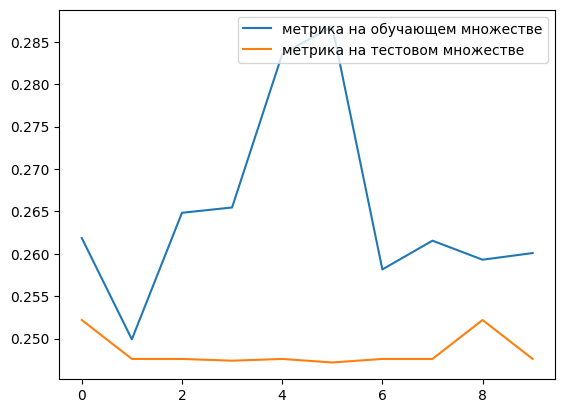

In [ ]:
plt.plot(train_f1, label='метрика на обучающем множестве')
plt.plot(test_f1, label='метрика на тестовом множестве')
plt.legend(loc='upper right');

In [ ]:
print(train_f1[-1], test_f1[-1])

tensor(0.2601) tensor(0.2476)


<p class="task" id="4"></p>

4\. Повторите решение задачи 3, создав слой `nn.Embedding` на основе предобученных векторов для слов русского языка и заморозив веса данного слоя. Для поиска векторов можете воспользоваться любым известным вам ресурсом. Сравните качество полученного решения и решения из предыдущей задачи, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [ ]:
!wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iGqEHyaNh8dXPQ

--2023-10-29 20:28:30--  https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iGqEHyaNh8dXPQ
Resolving getfile.dokpub.com (getfile.dokpub.com)... 142.132.255.217
Connecting to getfile.dokpub.com (getfile.dokpub.com)|142.132.255.217|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloader.disk.yandex.ru/disk/da5682e1df61edcf9865e21b2592d0ea241040831c9e23876e0cf604ec202c5b/653eea1e/AG33Ud1JnkA80Wt70G9OAcbQWSZUlJA1BDeBl9sHoCE6gRJeO3Y_jHcKd7GAzgUzIwKeHO5YegVpTxNNYbZEfQ%3D%3D?uid=0&filename=ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz&disposition=attachment&hash=7tQDF8dBavqviAZVvJxubxqrfqGNnxYU/%2B4V4CEz3F/exLizSHvsKwfTHlvZV45nq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fx-gzip&owner_uid=819372643&fsize=394697055&hid=72a619c9288f3b9e0fb88e59daefa07f&media_type=compressed&tknv=v2 [following]
--2023-10-29 20:28:31--  https://downloader.disk.yandex.ru/disk/da5682e1df61edcf9865e21b2592d0ea241040831c9e23876e0cf604ec202c

In [ ]:
import gzip
dct = {}
with gzip.open('iGqEHyaNh8dXPQ', 'rb') as f:
  for line in f.readlines():
    text = line.decode()
    word, vec = text.split(' ', maxsplit=1)
    word = word.split('_')[0]
    vec = list(map(lambda x: float(x), vec.split()))
    dct[word] = vec
dct['<unk>'] = [1/3] * len(vec)

In [ ]:
embeddings_t = []
for word in vocab_train.get_stoi().keys():
    try:
        embeddings_t.append(dct[word])
    except KeyError:
        embeddings_t.append(dct['<unk>'])

In [ ]:
len(embeddings_t)

165634

In [ ]:
embeddings_t = th.tensor(embeddings_t)

In [ ]:
class Net(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, out_features):
    super().__init__()
    self.emb = nn.Embedding.from_pretrained(embeddings_t)
    self.emb.weight.requires_grad_(False)
    # self.emb = nn.Embedding(
    #     num_embeddings = num_embeddings, embedding_dim = embedding_dim
    #   )
    self.fc1 = nn.Linear(
        in_features = embedding_dim, out_features = 50
      )
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(
        in_features = 50, out_features = out_features
      )

  def forward(self, X):
    e = self.emb(X)
    e = e.mean(dim=1)
    out = self.fc1(e)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
%%time
model = Net(
    num_embeddings=len(vocab_train),
    embedding_dim=300,
    out_features=4
    )

lr = 0.1
n_epochs = 2

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_f1, test_f1 = [], []

for epoch in range(n_epochs):
    print(epoch)
    train_losses = []
    f1_m = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_, y_ in dl:
        out = model(X_)
        loss = crit(out, y_)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

        f1_m.update(out.argmax(dim=1), y_)

    losses.append(th.tensor(train_losses).mean())
    f1_epochs = f1_m.compute()
    train_f1.append(f1_epochs)

    model.eval()
    f1_m_test = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_test, y_test in dl_test:
        out = model(X_test)
        f1_m_test.update(out.argmax(dim=1), y_test)
    f1_epochs_test = f1_m_test.compute()
    test_f1.append(f1_epochs_test)
    model.train()

0
1
CPU times: user 1min 34s, sys: 1min 16s, total: 2min 50s
Wall time: 2min 51s


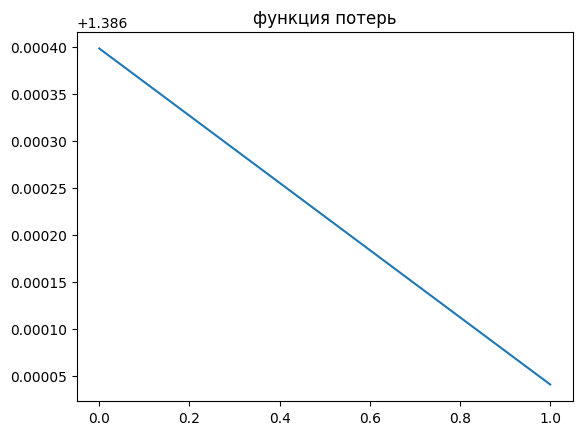

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('функция потерь');

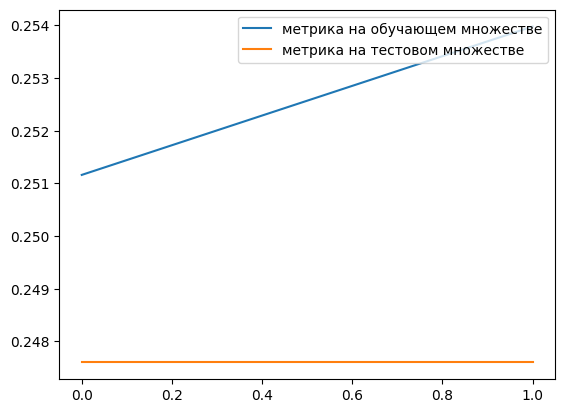

In [ ]:
plt.plot(train_f1, label='метрика на обучающем множестве')
plt.plot(test_f1, label='метрика на тестовом множестве')
plt.legend(loc='upper right');

In [ ]:
print(train_f1[-1], test_f1[-1])

tensor(0.2540) tensor(0.2476)


In [ ]:
# другой вокаб нужен, те создать новый вокаб на новых данных

<p class="task" id="5"></p>

5\. Повторите решение задачи 3, не замораживая веса слоя эмбеддингов. Сравните качество полученного решения и решений из предыдущих задач, а также время, затраченное на обучения моделей.  

- [ ] Проверено на семинаре

In [ ]:
class Net(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, out_features):
    super().__init__()
    self.emb = e = nn.Embedding.from_pretrained(embeddings_t)
    self.fc1 = nn.Linear(
        in_features = embedding_dim, out_features = 50
      )
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(
        in_features = 50, out_features = out_features
      )

  def forward(self, X):
    e = self.emb(X)
    e = e.mean(dim=1)
    out = self.fc1(e)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
%%time
model = Net(
    num_embeddings=len(vocab_train),
    embedding_dim=300,
    out_features=4
    )

lr = 0.1
n_epochs = 2

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
train_f1, test_f1 = [], []

for epoch in range(n_epochs):
    print(epoch)
    train_losses = []
    f1_m = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_, y_ in dl:
        out = model(X_)
        loss = crit(out, y_)
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad()

        f1_m.update(out.argmax(dim=1), y_)

    losses.append(th.tensor(train_losses).mean())
    f1_epochs = f1_m.compute()
    train_f1.append(f1_epochs)

    model.eval()
    f1_m_test = torchmetrics.F1Score(task="multiclass", num_classes=4)
    for X_test, y_test in dl_test:
        out = model(X_test)
        f1_m_test.update(out.argmax(dim=1), y_test)
    f1_epochs_test = f1_m_test.compute()
    test_f1.append(f1_epochs_test)
    model.train()

0


/usr/local/lib/python3.10/dist-packages/torch/_jit_internal.py:1355: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(


1
CPU times: user 29.1 s, sys: 23 s, total: 52.2 s
Wall time: 56.3 s


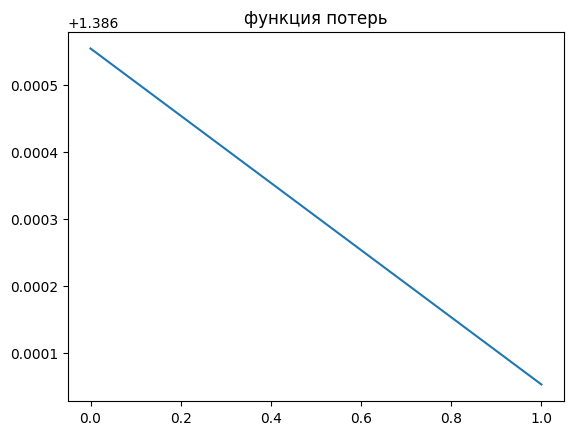

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('функция потерь');

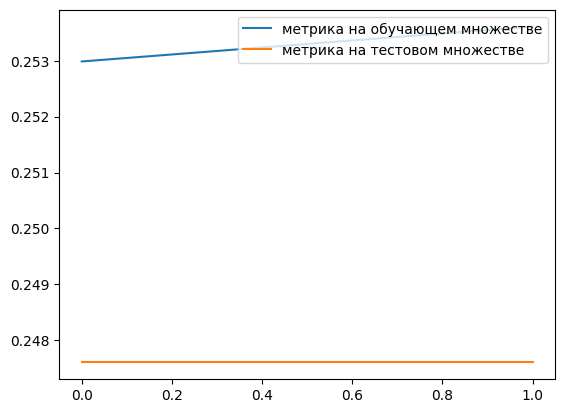

In [ ]:
plt.plot(train_f1, label='метрика на обучающем множестве')
plt.plot(test_f1, label='метрика на тестовом множестве')
plt.legend(loc='upper right');

In [ ]:
print(train_f1[-1], test_f1[-1])

tensor(0.2536) tensor(0.2476)


<p class="task" id="6"></p>

6\. Воспользовавшись обученной моделью из предыдущей задачи, визуализируйте эмбеддинги новостей из тестовой выборки в двумерном пространстве. Для проекции точек в двумерное пространство воспользуйтесь алгоритмом t-SNE. Раскрасьте точки в цвет, соответствующий классу новости.

- [ ] Проверено на семинаре

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
X_test = nws_train[:][0]
y_test = nws_train[:][1]

X_emb = model.emb(X_test).mean(dim=1)


X_tsne = TSNE().fit_transform(X_emb)

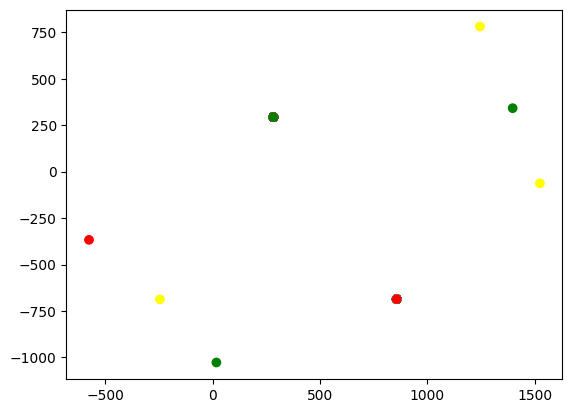

In [ ]:
fig, ax = plt.subplots()

for class_ in range(4):
  ind = np.where(y_test == class_)
  ax.scatter(X_tsne[ind, 0], X_tsne[ind, 1], label=class_)
plt.legend()
plt.show();

## Обратная связь
- [x] Хочу получить обратную связь по решению